In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from functions import colorize, complex_correlation, fidelity

# for Jupyter lab
# %matplotlib widget
# for Jupyter notebook
# %matplotlib notebook
%matplotlib inline

data_folder = '../Data'

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
## use fidelity or correlation to compare matrices

function = fidelity
# function = complex_correlation

# 1. First load the params and data

## Load parameters

In [3]:
path = os.path.sep.join([data_folder,'param.json'])
with open(path,'r') as f:
    param = json.load(f)
    print('Succesfully loaded parameters from .json file')

Succesfully loaded parameters from .json file


## Load theoretical modes

In [4]:
path = os.path.sep.join([data_folder,'conversion_matrices.npz'])

data_dict = np.load(path)
# list of the radial momenta of the modes
L = data_dict['L_modes']
# list of the angular orbital momebta of the modes
M = data_dict['M_modes']
modes_in = data_dict.f.modes_in
# create mode matrix for two polarizations
modes_in_full = np.kron(np.array([[1,0],[0,1]]),modes_in)
# number of input pixels
m = np.int(np.sqrt(modes_in.shape[1]))
modes_out = data_dict.f.modes_out
modes_out_full = np.kron(np.array([[1,0],[0,1]]),modes_out)
# number of output pixels
n = np.int(np.sqrt(modes_out.shape[1]))

## Load the TMs

In [5]:
TM_modes = []
for i, pos in enumerate(param['Translation']['steps_pressure']):
    path = os.path.sep.join([data_folder,f'TM_modes_{str(pos)}.npz'])
    data_dict = np.load(path)
    TM_modes.append(data_dict.f.TM_corr_modes)
TM_modes = np.array(TM_modes)
Nmodes = TM_modes.shape[-1]//2

# 2. Decorrelation of the TM

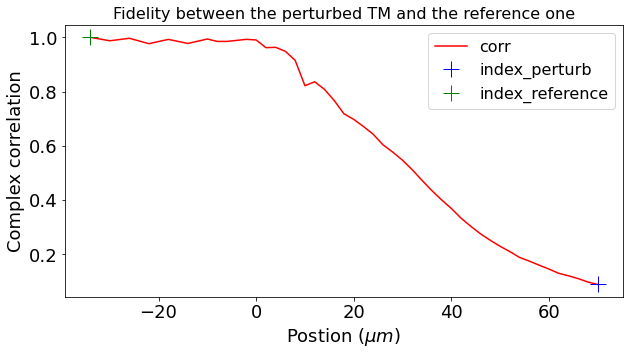

In [6]:
index = -1
index_dx0 = 17
index_reference = 5
TM_perturb = TM_modes[index]
TM_ref = TM_modes[index_reference]
TM_correlation = []

dx = (np.array(param['Translation']['steps_pressure'])-param['Translation']['steps_pressure'][index_dx0])*1e3
for i,TM in enumerate(TM_modes):
    TM_correlation.append(function(TM_modes[index_reference],TM))
plt.figure(figsize=(10,5)),
plt.plot(dx[index_reference:],TM_correlation[index_reference:],'r')
plt.plot([dx[index]],[TM_correlation[index]],'b+', markersize=16)
plt.plot([dx[index_reference]],[TM_correlation[index_reference]],'g+', markersize=16)
plt.legend(['corr','index_perturb','index_reference'])
plt.xlabel(r'Postion ($\mu m$)')
plt.ylabel('Complex correlation');
plt.title('Fidelity between the perturbed TM and the reference one');

# save figure
# plt.savefig('corrTM.svg', dpi=400)

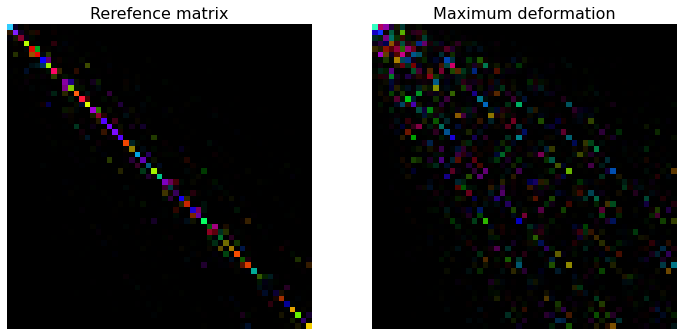

In [7]:
to_img = lambda x: colorize(x, beta = 1.8, max_threshold = 0.8)


mode = 'half'

if mode == 'half':
    n_end = Nmodes
elif mode == 'full':
    n_end = 2*Nmodes

fig ,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].imshow(to_img(TM_ref[:n_end,:n_end]), interpolation = 'None')
ax[0].axis('off')
ax[0].set_title('Rerefence matrix')
ax[1].imshow(to_img(TM_perturb[:n_end,:n_end]), interpolation = 'None')
ax[1].axis('off')
ax[1].set_title('Maximum deformation')
plt.show()
#fig.savefig('TMs_complex_deform_half.svg', dpi = 'figure')

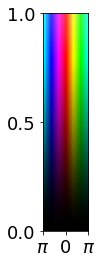

In [8]:
n_phi = 30
n_amp = 100
X,Y = np.meshgrid(np.linspace(-np.pi,np.pi,n_phi),np.linspace(1.,0.,n_amp))

cm = Y*np.exp(1j*X)

fig, ax = plt.subplots(1,1)
img = ax.imshow(to_img(cm.transpose()), extent = [-np.pi, np.pi, 0., 1.], aspect = 30)

ax.set_xticks([-np.pi,0,np.pi])
ax.set_xticklabels([r'$\pi$', '0', r'$\pi$'])
ax.set_yticks([0,0.5,1]);
# plt.savefig('cm_for_complex_TMs.svg', dpi = 200)

# 3. Channels robust to deformation
Deformation principal modes obtained from the eigenmodes of the Generalized Wigner-Smith operator 
(Fig.3 of the main text)

## Estimate the Wigner-Smith operator

In [9]:
def get_WS(H0,H1,H2):
    '''
    Get the Wigner-Smith operator from 3 matrices at Dx-dx, Dx and Dx+dx
    '''
    dH = (H2 - H0)*0.5
    WS = -1j*np.linalg.pinv(H1)@dH
    return WS

def get_WS_symm(H0,H1,H2):
    '''
    Get the Hermitian part of the Wigner-Smith operator from 3 matrices at Dx-dx, Dx and Dx+dx
    '''
    WS = get_WS(H0,H1,H2)
    WS_symm = WS + WS.T.conj()
    return WS_symm


# central deformation to estimate the WS operator
center_TM_index = 24
# step to evaluate the derivative
step = 4

WS_symm = get_WS_symm(TM_modes[center_TM_index - step], 
                      TM_modes[center_TM_index], 
                      TM_modes[center_TM_index + step])

## Eigenvalue decomposition of the Wigner-Smith operator

In [10]:
s,U = np.linalg.eig(WS_symm)
# sort the eigenvalues
s = s[np.argsort(s)]
U = U[np.argsort(s),:]

## Analyze the (de)correlation of the deformation principal modes
compared to the fundamental mode and to random input wavefronts

In [11]:
def get_out_states(in_modes, i0, i1):
    '''
    Get the output states corresponding to the input state 'in_modes'
    for the deformations indexed by 'i0' and 'i1'.
    Return the output fields for the two polarizations for each deformation. 
    '''
    output_state = TM_modes[i0] @ in_modes
    out_pix = modes_out_full.transpose()@output_state
    out_pix_p1_0 = out_pix[:n**2].reshape([n]*2)
    out_pix_p2_0 = out_pix[n**2:].reshape([n]*2)

    output_state = TM_modes[i1] @ in_modes
    out_pix = modes_out_full.transpose()@output_state
    out_pix_p1_f = out_pix[:n**2].reshape([n]*2)
    out_pix_p2_f = out_pix[n**2:].reshape([n]*2)
    
    return out_pix_p1_0, out_pix_p2_0, out_pix_p1_f, out_pix_p2_f

def get_correlation_out(in_modes, indexes, index_reference):
    '''
    Take as argument an input wavefront 'in_modes' (in the mode basis), 
    a list of indexes 'indexes' and the reference index 'index_reference'.
    Returns a list of values representing the 
    correlation of the output intensity  
    for each deformation indexed by 'indexes' 
    with the output intensity for the reference deformation 
    indexed by 'index_reference'
    '''
    corr_vector = []
    f = lambda x: np.abs(x)**2
    for ind in indexes:
        out_pix_p1_0, out_pix_p2_0, out_pix_p1_f, out_pix_p2_f = get_out_states(in_modes, i0 = index_reference, i1 = ind)
        out_0 = np.concatenate([out_pix_p1_0,out_pix_p2_0])
        out_f = np.concatenate([out_pix_p1_f,out_pix_p2_f])
        corr_vector.append(complex_correlation(f(out_0),f(out_f)))
    return corr_vector    

In [12]:
Nmodes = TM_modes[0].shape[0]
# compare to the deformation around witch the WS operator is estimated.
index_reference = center_TM_index
# number of average random wavefront to average on
n_ave = 20


## DEFORMATION PRINCIPAL MODES
indexes = list(range(len(TM_modes)))
correlations_WS = []
for ind in range(Nmodes):
    state_WS = U[:,ind] # use WS eigen vector
    correlations_WS.append(get_correlation_out(state_WS, 
                                               indexes = indexes, 
                                               index_reference = index_reference))
## FUNDAMENTAL MODE
correlations_mode = []
state = np.zeros(Nmodes, dtype = np.complex) # use the modes 
# send the fundamental mode in one polarization
state[55] = 1
correlations_mode = get_correlation_out(state, indexes = indexes, index_reference = index_reference)

## RANDOM WAVEFRONTS
correlations_rand_avg = np.zeros(len(TM_modes))
for j in range(n_ave):
    # generate a random combination of mode as input
    rand_vec = (np.random.rand(Nmodes)-0.5) + 1j * (np.random.rand(Nmodes)-0.5)
    output_states_rand = [TM_modes[i] @ rand_vec for i in range(len(TM_modes))]
    correlations_rand = np.array([complex_correlation(output_states_rand[i],output_states_rand[index_reference]) for i in range(len(TM_modes))])
    correlations_rand_avg += correlations_rand
correlations_rand_avg /= n_ave

## Plot output intensity correlation data 

In [13]:
from matplotlib import colors

def get_color_map(n):
    cdict = {'red':   ((0.0,  0.3, 0.3),
                       (1.0,  1.0, 1.0)),

             'green': ((0.0,  0.1, 0.1),
                       (1.,  0., 0.)),

             'blue':  ((0.0,  0.0, 0.0),
                       (1.0,  0.0, 0.0))}
    cmap = colors.LinearSegmentedColormap('custom', cdict, N=n)
    return cmap

Text(0.5, 1.0, 'Stability of deformation principal modes')

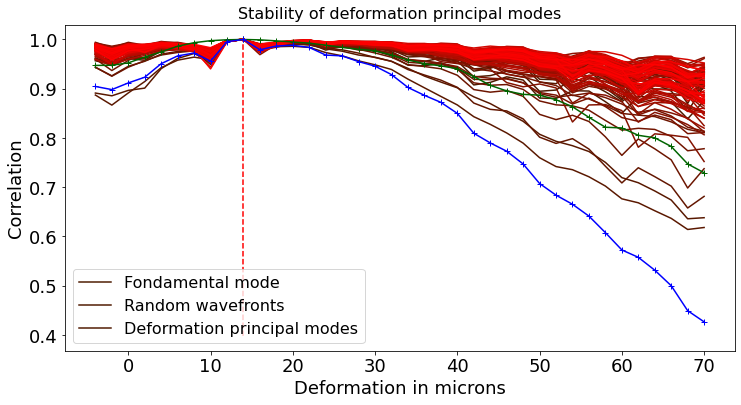

In [14]:
i0 = 15
index_dx0 = 17
plt.close('all')
plt.figure(figsize = (12,6))
dx = (np.array(param['Translation']['steps_pressure'])-param['Translation']['steps_pressure'][index_dx0])*1e3
cmap = get_color_map(n = Nmodes)

for i,corr_WS in enumerate(correlations_WS):
    plt.plot(dx[i0:],corr_WS[i0:],color = cmap(i))
    

plt.plot(dx[i0:],correlations_mode[i0:], color = 'darkgreen', marker='+')

plt.plot(dx[i0:],correlations_rand_avg[i0:],'b+-')
all_min = plt.gca().get_ylim()[0]
plt.vlines(dx[center_TM_index],all_min,1., 'r', linestyles = 'dashed')

plt.legend(['Fondamental mode', 'Random wavefronts', 'Deformation principal modes'])
plt.xlabel('Deformation in microns')
plt.ylabel('Correlation')
plt.title('Stability of deformation principal modes')
# save figure
# plt.savefig('WS_corr.svg')

## Display output intensity patterns

### Fundamental mode

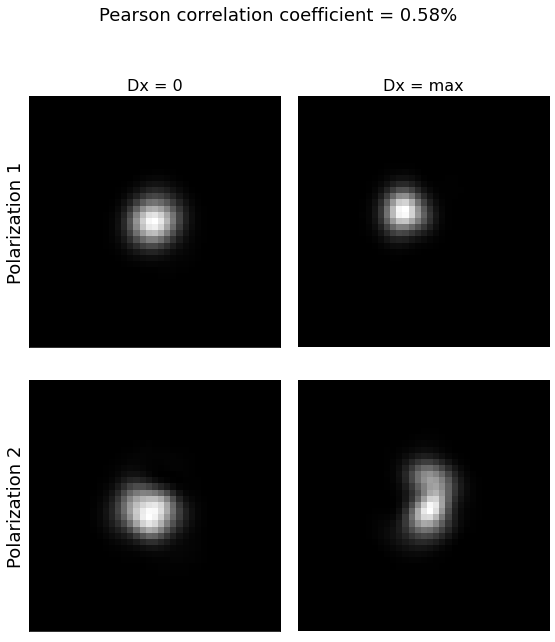

In [15]:
in_state = np.zeros(Nmodes) # use the modes 
in_state[0] = 1

# to_img = colorize
to_img = lambda x: np.abs(x)**2
cmap = 'gray'

out_pix_p1_0, out_pix_p2_0, out_pix_p1_f, out_pix_p2_f = get_out_states(in_state,
                                                                       i0 = index_dx0,
                                                                       i1 = -1)
out_0 = to_img(np.concatenate([out_pix_p1_0,out_pix_p2_0]))
out_f = to_img(np.concatenate([out_pix_p1_f,out_pix_p2_f]))
corr = complex_correlation(out_0,out_f)

plt.figure(figsize = (8,9))
plt.subplot(221)
plt.imshow(to_img(out_pix_p1_0), cmap = cmap)
plt.title('Dx = 0')
plt.xticks([],[]); plt.yticks([],[]); 
plt.ylabel('Polarization 1')
plt.subplot(223)
plt.imshow(to_img(out_pix_p2_0), cmap = cmap)
plt.ylabel('Polarization 2')
plt.xticks([],[]); plt.yticks([],[]); 

plt.subplot(222)
plt.imshow(to_img(out_pix_p1_f), cmap = cmap)
plt.title('Dx = max')
plt.axis('off')
plt.subplot(224)
plt.imshow(to_img(out_pix_p2_f), cmap = cmap)
plt.axis('off')
plt.subplots_adjust(top=0.9)
plt.suptitle(f'Pearson correlation coefficient = {corr:.2f}%', y=1.02)
plt.tight_layout()

# save figure
# plt.savefig('fundamental_mode.svg')

### Random wavefront

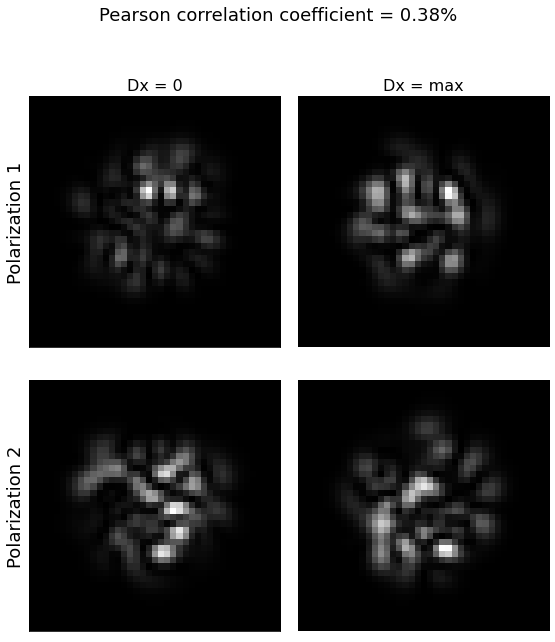

In [16]:
rand_vec = (np.random.rand(Nmodes)-0.5) + 1j * (np.random.rand(Nmodes)-0.5)

out_pix_p1_0, out_pix_p2_0, out_pix_p1_f, out_pix_p2_f = get_out_states(rand_vec,
                                                                       i0 = index_dx0,
                                                                       i1 = -1)
out_0 = to_img(np.concatenate([out_pix_p1_0,out_pix_p2_0]))
out_f = to_img(np.concatenate([out_pix_p1_f,out_pix_p2_f]))
corr = complex_correlation(out_0,out_f)

plt.figure(figsize = (8,9))
plt.subplot(221)
plt.imshow(to_img(out_pix_p1_0), cmap = cmap)
plt.ylabel('Polarization 1')
plt.xticks([],[]); plt.yticks([],[]); 
plt.title('Dx = 0')
plt.subplot(223)
plt.imshow(to_img(out_pix_p2_0), cmap = cmap)
plt.ylabel('Polarization 2')
plt.xticks([],[]); plt.yticks([],[]); 

plt.subplot(222)
plt.imshow(to_img(out_pix_p1_f), cmap = cmap)
plt.title('Dx = max')
plt.axis('off')
plt.subplot(224)
plt.imshow(to_img(out_pix_p2_f), cmap = cmap)
plt.axis('off')
plt.subplots_adjust(top=0.9)
plt.suptitle(f'Pearson correlation coefficient = {corr:.2f}%', y=1.02)
plt.tight_layout()


# save figure
# plt.savefig('rand.svg')

### First deformation principal modes

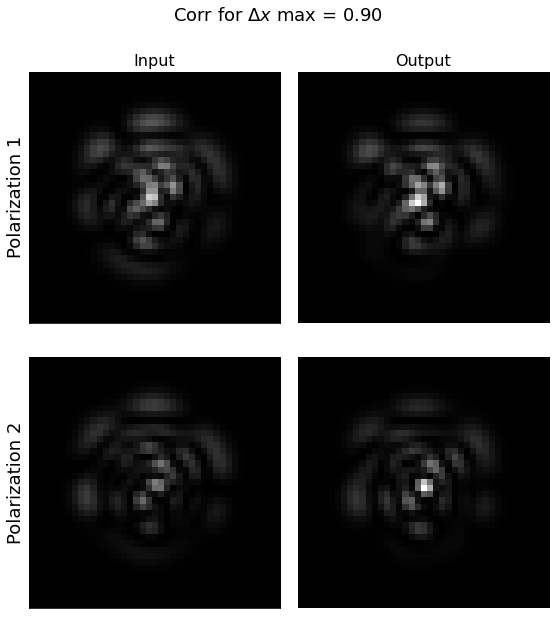

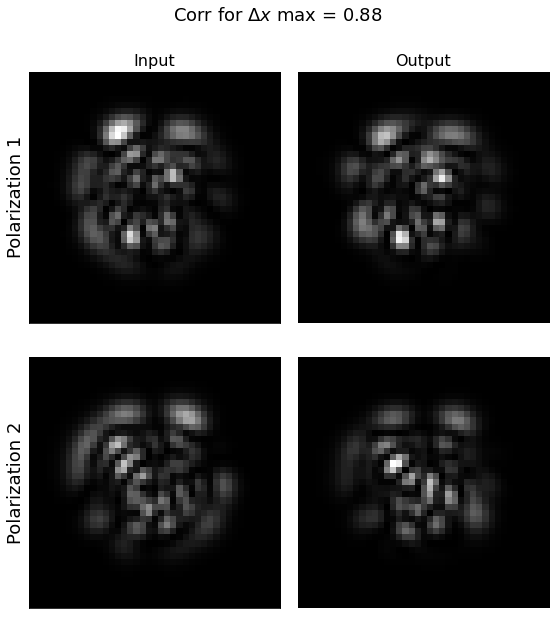

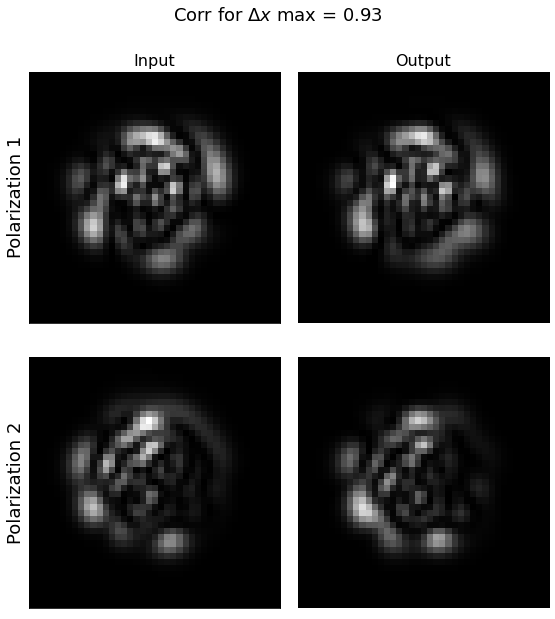

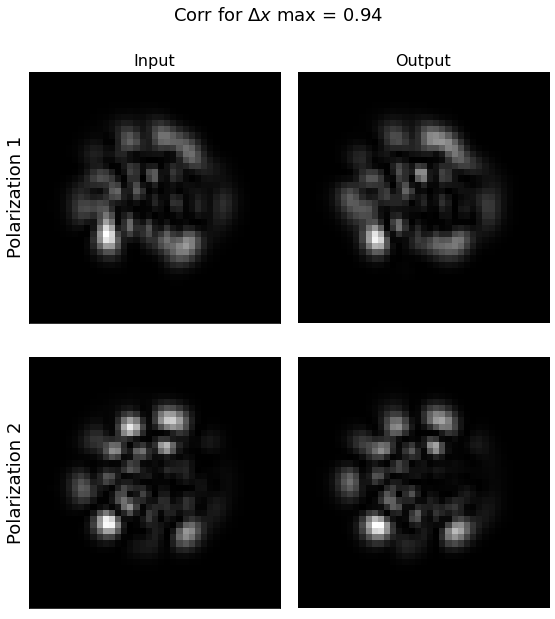

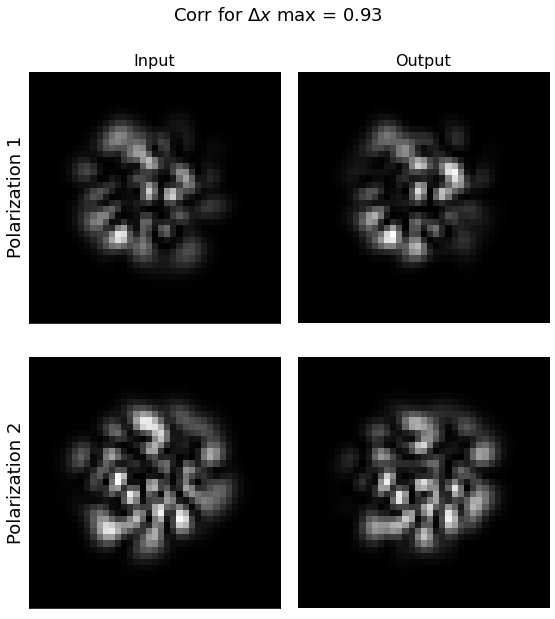

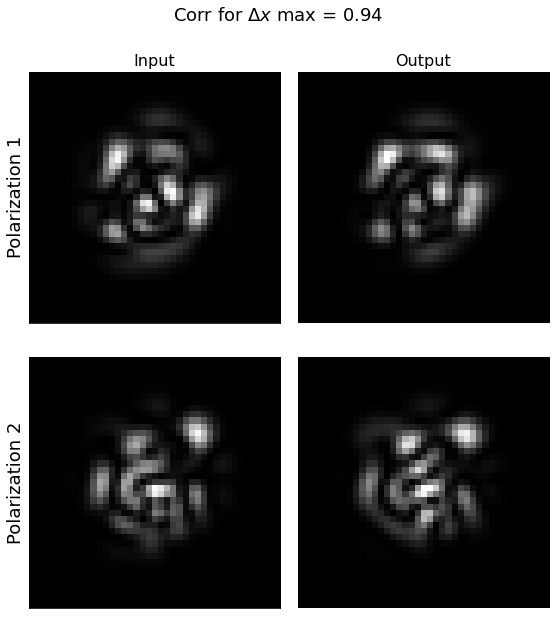

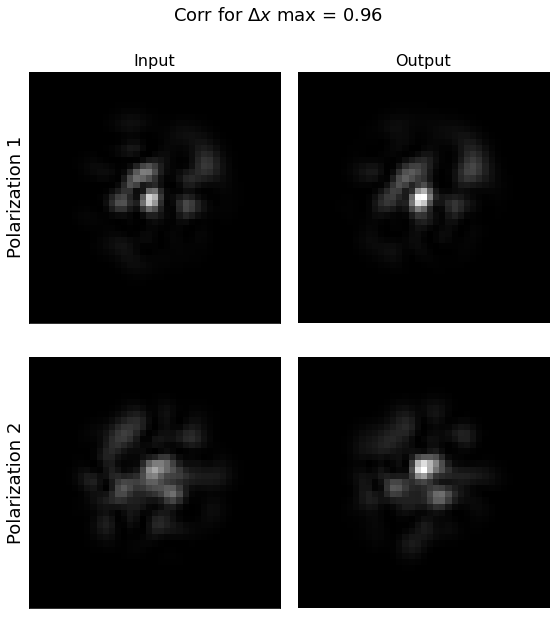

In [17]:
max_ind = np.argmax([c[-1] for c in correlations_WS])
cmap = 'gray'
to_img = lambda x: np.abs(x)**2

for ind in list(range(6))+[max_ind]:
    state_WS = U[:,ind] # use WS eigen vector
    out_pix_p1_0, out_pix_p2_0, out_pix_p1_f, out_pix_p2_f =  get_out_states(state_WS,
                                                                   i0 = index_dx0,
                                                                   i1 = -1)
    
    max_1 = np.max([np.max(to_img(out_pix_p1_0)),np.max(to_img(out_pix_p1_f))])
    max_2 = np.max([np.max(to_img(out_pix_p2_0)),np.max(to_img(out_pix_p2_f))])
    
    plt.figure(figsize=(8,9))
    plt.subplot(221)
    plt.imshow(to_img(out_pix_p1_0), vmax = max_1, cmap = cmap)
    plt.title('Input')
    plt.ylabel('Polarization 1')
    plt.xticks([],[]); plt.yticks([],[]); 
    plt.subplot(223)
    plt.imshow(to_img(out_pix_p2_0), vmax = max_2, cmap = cmap)
    plt.ylabel('Polarization 2')
    plt.xticks([],[]); plt.yticks([],[]); 
    
    plt.subplot(222)
    plt.imshow(to_img(out_pix_p1_f), vmax = max_1, cmap = cmap)
    plt.title('Output')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(to_img(out_pix_p2_f), vmax = max_2, cmap = cmap)
    plt.axis('off')
    
    plt.suptitle(rf'Corr for $\Delta x$ max = {correlations_WS[ind][-1]:.2f}')
    plt.tight_layout()
    # save figure
#     plt.savefig(f'WS_mode_{ind}.svg')

## Projection of the deformation principal modes on the fiber modes

In [18]:
labels_modes = list(range(0,Nmodes//2,10))*2
ticks_modes = list(range(0,Nmodes,10))

ticks_modes

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

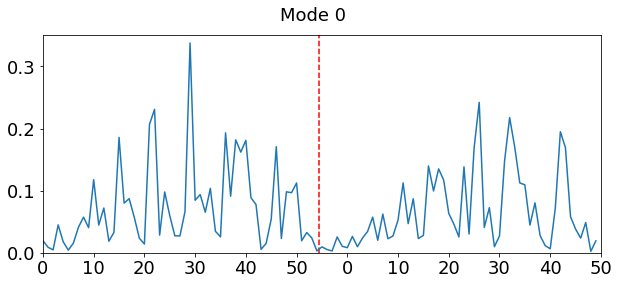

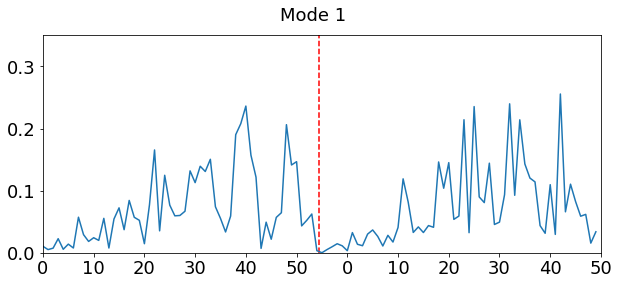

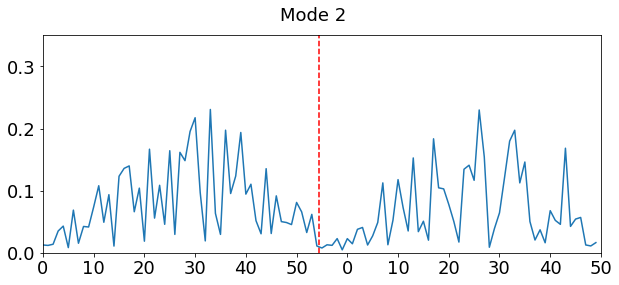

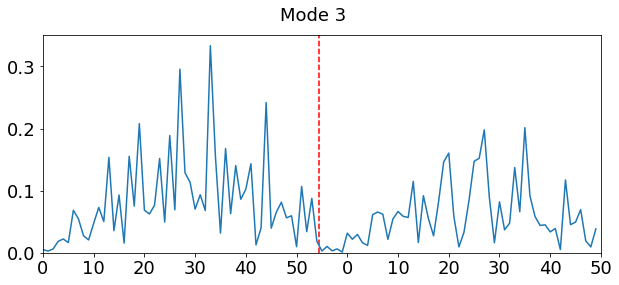

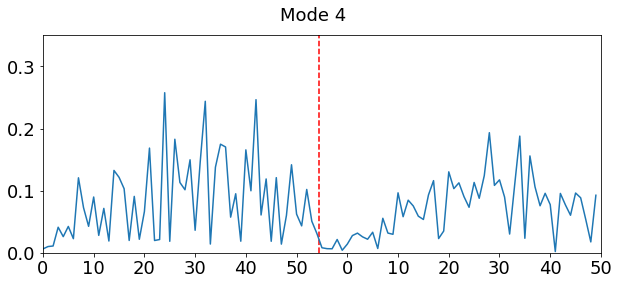

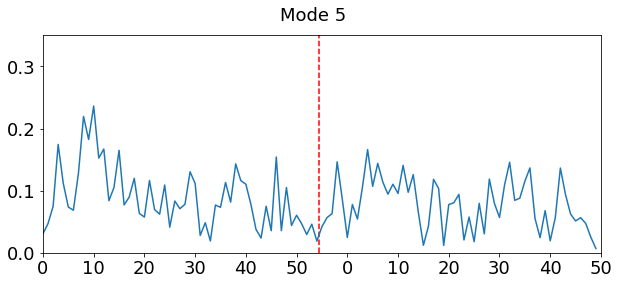

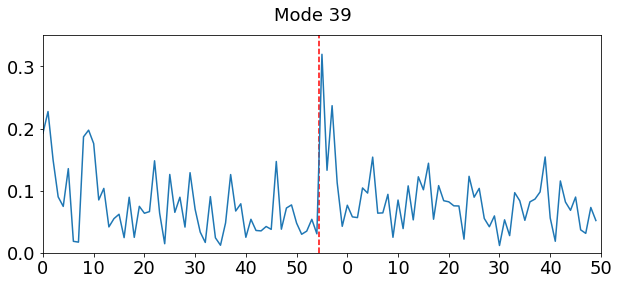

In [19]:
max_ind = np.argmax([c[-1] for c in correlations_WS])
for ind in list(range(6))+[max_ind]:
    proj = np.abs(U[:,ind]) 
    
    plt.figure(figsize = (10,4))
    plt.plot(proj)
    plt.ylim(0,0.35)
    plt.xlim([0,Nmodes-1])
    labels_modes = list(range(0,Nmodes//2,10))*2
    ticks_modes = list(range(0,Nmodes+1,10))
    plt.xticks(ticks = ticks_modes, labels = labels_modes)
    plt.vlines(54.5,0,1., 'r', linestyles = 'dashed')
    plt.suptitle(rf'Mode {ind:g}')
    
#     plt.savefig(f'mode_proj_{ind}.svg')

# 4. SVD of the deformation operator as a function of $\Delta x$ (~PCA)
(Fig.4 of the main text)

### Calculation of the deformation operator
$D(t) = H^{-1}(\Delta z = 0)\times H(\Delta z) -I$

In [20]:
index_min_svd = index_dx0
index_max_svd = 52
# index of the reference matrix
index_reference = index_min_svd

evolutionTMs = np.array([TM@np.linalg.pinv(TM_modes[index_reference])-np.eye(TM.shape[0]) for TM in TM_modes])
evolution_vec = evolutionTMs.reshape([evolutionTMs.shape[0],-1]).transpose()

## Singular valude decomposition

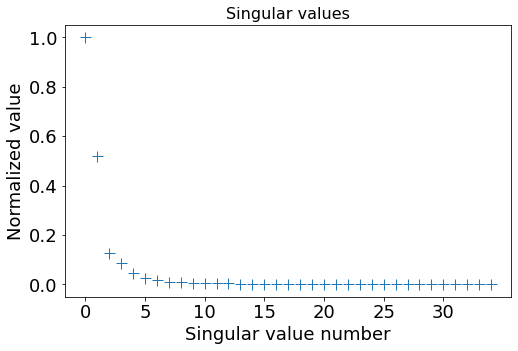

In [21]:
u,s,v = np.linalg.svd(evolution_vec[:,index_min_svd:index_max_svd],full_matrices = False)

n = len(s)
xticks = list(range(0,n,5))
yticks = list(np.arange(0,1.1,0.2))


fig, ax = plt.subplots(1,1, figsize = (8,5))
img = ax.plot(s/s[0],'+', markersize = 11)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.set_yticks(yticks)
ax.set_yticklabels([f'{i:.1f}' for i in yticks])
ax.set_ylabel('Normalized value')
ax.set_xlabel('Singular value number')
plt.title('Singular values');

# save figure
# plt.savefig('svdD.svg', dpi = 300)

## Singular value distribution  

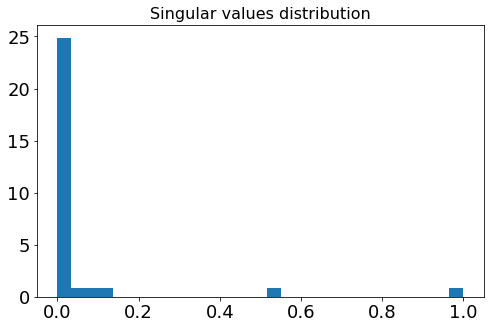

In [22]:
dist_bins = np.linspace(0,1,30)
plt.figure(figsize = (8, 5))
plt.hist(s/s[0], bins = dist_bins, density=True);
ax.set_ylabel('Probability density')
ax.set_xlabel('Normalized value')
plt.title('Singular values distribution');

# save figure
# plt.savefig('svdD_dist.svg', dpi = 300)

0.9794973604143481


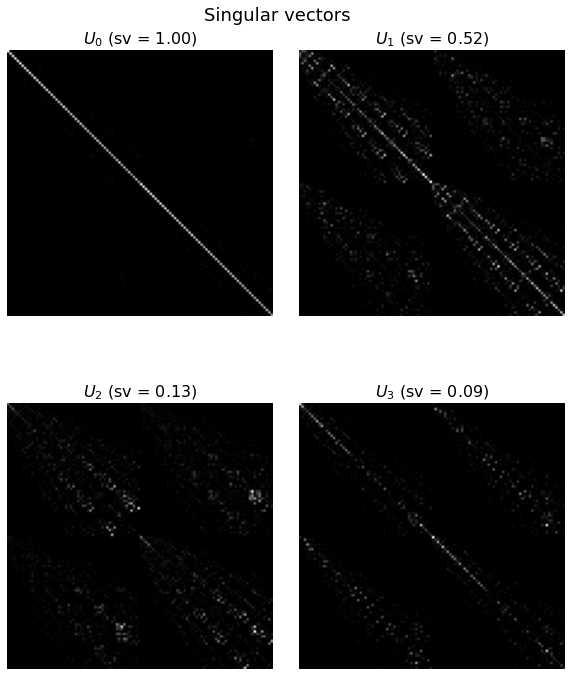

In [23]:
n_max = Nmodes

cmap = 'gray'

# to_img = lambda x: colorize(x, beta = 1.8)
to_img = lambda x: np.abs(x)**2

U = u.reshape([Nmodes]*2+[u.shape[-1]])
fig, ax = plt.subplots(2,2, figsize = (10,10))
plt.subplots_adjust(wspace = 0.1, hspace = 0.0, top = 0.98, bottom = 0)
ax[0,0].imshow(to_img(U[:n_max,:n_max,0]),cmap)
ax[0,0].axis('off')
ax[0,0].set_title(fr'$U_0$ (sv = {s[0]/s[0]:.2f})')
ax[0,1].imshow(to_img(U[:n_max,:n_max,1]),cmap, vmax = np.max(to_img(U[:n_max,:n_max,2]))*0.75)
# ax[0,1].imshow(to_img(U[:n_max,:n_max,1]),cmap)
ax[0,1].axis('off')
ax[0,1].set_title(fr'$U_1$ (sv = {s[1]/s[0]:.2f})')
ax[1,0].imshow(to_img(U[:n_max,:n_max,2]),cmap)
ax[1,0].axis('off')
ax[1,0].set_title(fr'$U_2$ (sv = {s[2]/s[0]:.2f})')
ax[1,1].imshow(to_img(U[:n_max,:n_max,3]),cmap)
ax[1,1].axis('off')
ax[1,1].set_title(fr'$U_3$ (sv = {s[3]/s[0]:.2f})')
plt.suptitle('Singular vectors')

# save figure
# plt.savefig('Ui.svg',dpi = 400)

print(np.sum(s[:2]**2)/np.sum(s**2))


## Show the map of close-by mode matrix
Map of the modes with 1 if the modes have a difference of angular and radial momentum below 1, 0 otherwise

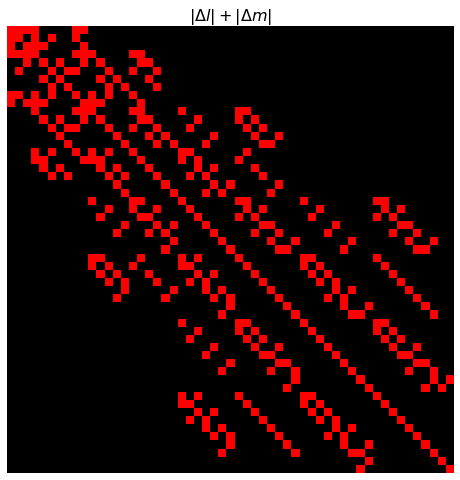

In [24]:
fig ,ax = plt.subplots(1,1, figsize = (8,8))
plt.subplots_adjust(wspace = 0.1, top = 1., bottom = 0)

ML = (np.abs(M) < 2)*(np.abs(L) < 2).astype(np.complex)
ax.imshow( colorize(ML),'jet', vmax = 1.1)
ax.set_title(r'$|\Delta l|+|\Delta m|$')
ax.axis('off');

# save figure
# plt.savefig('Deltam_Deltal.svg',dpi = 400)

## Approximate TM using the first singular components

In [25]:
def correlation_with_approx(TM0, TM1, U, alpha, n_sv = 2):
    '''
    Calculates the correlation between the measured matrix and the one 
    estimated using only the first 'n_sv' singular components with weights 'alpha'.
    'TM0' is the reference matrix and 'TM1' the one we want to approximate.
    'U' are the singular vectors.
    '''
    new_TM = np.zeros_like(TM0)
    for i in range(n_sv):
        new_TM += alpha[i] * U[...,i]

    new_TM = np.copy(TM0)+new_TM@np.copy(TM0)
    corr = function(TM1, new_TM)

    return corr

In [26]:
index_min_to_show = 10
# number of singular vector/values to keep in the estimation
n_sv = 2

v2 = np.diag(1./s)@u.transpose().conjugate()@evolution_vec[:,index_min_to_show:]

def get_reduced_sv_TM(index, n_sv, display = False):
    '''
    Approximate the evolution operator with the 'n_sv' first singular vectors
    and return the correlation between the true 'index'-th matrix and 
    the estimated one.
    '''
    SVh = (np.diag(s)@v2[:,index])
    alphas = SVh[:n_sv]
    return correlation_with_approx( TM_modes[index_min_svd], 
                          TM_modes[index_min_to_show+index], 
                          U, 
                          alpha = alphas, 
                          n_sv = n_sv) 

## Plot the correlation between approximate matrices and true ones

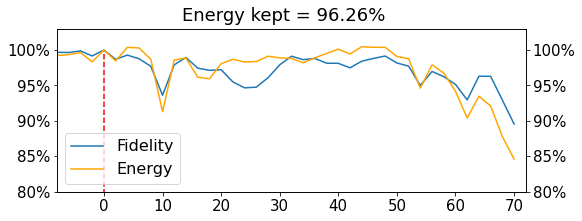

In [27]:
mask = np.zeros_like(s)
mask[:n_sv] = 1.
T0 = TM_modes[index_reference,...]
evolution_vec_estim = (u*(s*mask))@v2
estimated_TMs = [T0+T@T0 for T in evolution_vec_estim.reshape([Nmodes]*2+[-1]).transpose(2,0,1)]
real_TMs = TM_modes[index_min_to_show:,...]
energy = [np.linalg.norm(A)**2/np.linalg.norm(B)**2 for A,B in zip(estimated_TMs,real_TMs)]
    
n_sv_vec = [n_sv]
corr_reduced_sv2 = [[get_reduced_sv_TM(i,n) for i in range(v2.shape[1])] for n in n_sv_vec] 

fig = plt.figure(figsize = (2.8*3,1*3))
ax1 = fig.add_subplot(111)
line1, = ax1.plot(dx[index_min_to_show:],corr_reduced_sv2[0])
ax1.vlines(dx[index_min_svd],0,1., 'r', linestyles = 'dashed')

y1min,y1max = 0.8, 1.03
ylocs1 = np.arange(y1min,y1max,0.05)
ax1.set_yticks(ylocs1)
ax1.set_yticklabels([rf'{i*100:g}%' for i in ylocs1], fontsize = 15)
ax1.set_ylim([y1min,y1max])
# xlocs = [f'{i:g}' for i in ax1.get_xticks()]
xticks = np.arange(0,80,10)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize = 15)
ax1.set_xlim([-8,72])

ax2 = plt.gca().twinx()
line2, = ax2.plot(dx[index_min_to_show:],energy, color = 'orange')
y2min,y2max = 0.8, 1.03
ylocs2 = np.arange(y2min,y2max,0.05)
ax2.set_ylim([y2min,y2max])
ax2.set_yticks(ylocs2)
ax2.set_yticklabels([rf'{i*100:g}%' for i in ylocs2], fontsize = 15)

energy_tot = np.linalg.norm(evolution_vec_estim)**2/np.linalg.norm(evolution_vec)**2
plt.suptitle(f'Energy kept = {energy_tot*100:.2f}%');
plt.legend((line1, line2), ['Fidelity', 'Energy'])

# save figure
# plt.savefig('SV_approx.svg')

## Amplitude of the coefficients $\alpha$ and $\beta$

In [28]:
alpha_coeffs = np.abs(np.diag(s)@v2)[0,:]
beta_coeffs = np.abs(np.diag(s)@v2)[1,:]
max_ab = np.max([np.max(alpha_coeffs), np.max(beta_coeffs)])

(array([-0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

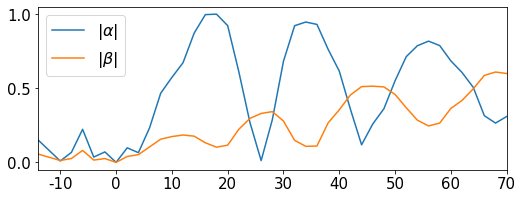

In [29]:
fig = plt.figure(figsize = (2.8*3,1*3))
ax1 = fig.add_subplot(111)
ax1.plot(dx[index_min_to_show:],
         alpha_coeffs/max_ab,
         label = r'$\|\alpha\|$')
ax1.plot(dx[index_min_to_show:],
         beta_coeffs/max_ab,
         label = r'$\|\beta\|$')
# ax1.vlines(dx[index_min_svd],0,1., 'r', linestyles = 'dashed')
plt.legend()

xticks = np.arange(-10,80,10)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize = 15)
ax1.set_xlim([-14,70])
plt.yticks(fontsize=15)

# plt.savefig('coeffs_alpha_beta.svg', dpi = 400)

## Display the evolution of the phase on the diagonal of the TM

In [30]:
TMs = TM_modes[index_min_to_show:,...]
Diags = np.stack([np.diag(T0[:Nmodes//2]/T[:Nmodes//2]) for T in TMs])

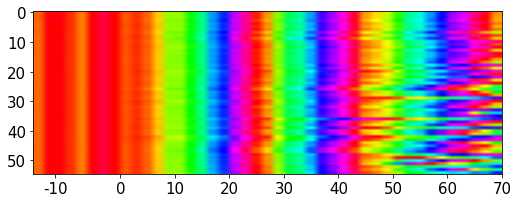

In [31]:
fig = plt.figure(figsize = (2.8*3,1*3))
ax1 = fig.add_subplot(111)
plt.imshow(colorize(Diags/np.abs(Diags)), aspect = 'auto')
xlabels = np.arange(-10,80,10)
xticks = [np.argmin(np.abs(dx-x))-index_min_to_show+.5 for x in xlabels]
ax1.set_xticks(xticks)
ax1.set_xticklabels(xlabels, fontsize = 15)

yticks = list(range(0,60,10))
ax1.set_yticks(yticks)
ax1.set_yticklabels(yticks, fontsize = 15);

# plt.savefig('phase_on_diag.svg', dpi = 400)

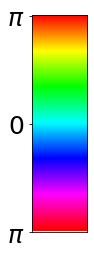

In [32]:
CM = np.ones([10,100], dtype = np.complex)
phase = np.linspace(0,2*np.pi,100)
CM*=np.exp(1j*phase)


fig = plt.figure(figsize = (1,4))
ax1 = fig.add_subplot(111)
plt.imshow(colorize(CM), aspect = 'auto')
ylabels = [r'$\pi$',r'$0$',r'$\pi$']
yticks = np.linspace(0,100,3)
ax1.set_yticks(yticks)
ax1.set_yticklabels(ylabels, fontsize = 25)
ax1.set_xticks([]);
# plt.savefig('cm.svg', dpi = 400)

## Energy loss during the deformation

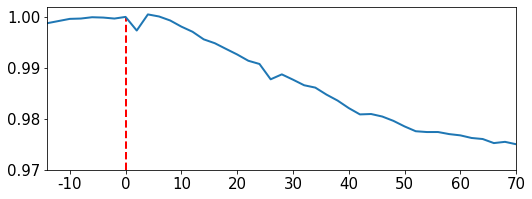

In [33]:
Energy_TM = np.array([np.linalg.norm(T)**2 for T in TMs])
Energy_TM /= np.linalg.norm(TM_modes[index_dx0,...])**2


fig = plt.figure(figsize = (2.8*3,1*3))
ax1 = fig.add_subplot(111)
ax1.plot(dx[index_min_to_show:],
         Energy_TM,
         linewidth = 2)
ax1.vlines(dx[index_min_svd],0.97,1., 
           'r', 
           linestyles = 'dashed',
           linewidth = 2)


xticks = np.arange(-10,80,10)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, fontsize = 15)
ax1.set_xlim([-14,70])
ax1.set_ylim([0.97,1.002])
plt.yticks(fontsize=15);

# plt.savefig('energy_loss.svg', dpi = 400)